
# Machine Learning Techniques - ISIS4219

Segundo Semestre - 2021



## Integrantes

*   Laura Natalia González García.
*   Nicolas Gustavo Gaitán Gómez.
*   David Camilo Bonilla Verdugo.



## **Problema**

Ante la situación actual de sanidad pública en el mundo a causa del COVID-19. La detección temprana de esta enfermedad en los pacientes, la automatización de procesos de diagnóstico y el apoyo a los diferentes expertos de esta enfermedad juega un papel muy importante para enfrentar una pandemia el cual ha registrado más de 230 millones de contagios, dejando sin vida a 4 millones de personas alrededor del mundo (OMS, 2021).

Sin embargo, todo este tiempo de cuarentena no solo ha servido para frenar la tasa de contagio del virus. También nos ha permitido recolectar diferentes radiografias de pacientes quienes han sufrido esta enfermedad, junto a otras enfermedades que pueden llegar a tener un una confusión con la enfermedad provocada por el virus. Por ello, es importante determinar con exactitud el tipo de enfermedad para poder recomendar el mejor tratamiento para el paciente.

Se han recolectado alrededor de 21 mil imágenes provenientes de diferentes paises del medio oriente como Catar, Pakistan y Malasia. Y, ante la reactivación económica que se quiere llevar a cabo, se teme una nueva ola de contagios, por lo que poder identificar estos casos dadas sus radiografías autmáticamente, sería de gran ayuda para los trabajadores de la Salud para determinar el tratamiento a los pacientes.

Para eso, le han pedido que construya un modelo capaz de recibir esas imágenes y determinar bajo que probabilidad puede pertenecer a cada una de las clases de las enfermedades proporcionadas. Y así mismo determinar cuál sería el diagnóstico de ese paciente. Como sugerencia, le han pedido construir una Red Neuronal Artificial (ANN) la cual permita realizar este proceso de manera automática y sin supervisión de los expertos en el tema. 

Finalmente, Ante la urgencia del problema, le han pedido que utilicen las imágenes en escala de grises para poder realizar una carga y un almacenamiento de manera más óptima, y utilizar directamente como entrada esta imagen.

**Fuente de Datos:** https://www.kaggle.com/preetviradiya/covid19-radiography-dataset

**Referencias:**

Coronavirus disease (COVID-19) – World Health Organization. (2021). Retrieved 5 October 2021, from https://www.who.int/emergencies/diseases/novel-coronavirus-2019?gclid=Cj0KCQjwwY-LBhD6ARIsACvT72PqduqyNWdB9YQ3awfqyC9FZ1y5Zy7srhp8wrVgEPPmzW4Jgll_Di8aAiDuEALw_wcB


## 1. Importando las librerias requeridas para el desarrollo del laboratorio


In [13]:
import pandas as pd
import numpy as np
import sys
import pathlib
import matplotlib.pyplot as plt
%matplotlib inline
from pandas_profiling import ProfileReport
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer
from keras.wrappers.scikit_learn import KerasClassifier

import tensorflow as tf
print('Tensorflow version:', tf.__version__)

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import reuters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping



Tensorflow version: 2.6.0


## 2. Perfilamiento y entendimiento de los datos

### Lectura de los datos
Se leen los metadatos de las imagenes almacenados en la tabla metadata.csv para el entendimiento del formato de las imagenes, su tamaño, y la clase a la que pertenecen

In [4]:
#Carga de metadata de las imágenes
data = pd.read_csv('metadata.csv')
data.head()

,Unnamed: 0,file_name,image_data_grayscale,file_format,image_shape,label
0,0,COVID-1.png,[[185 40 0 ... 0 24 131]\n [ 75 14 0 ...,PNG,"(299, 299)",COVID
1,1,COVID-10.png,[[135 133 131 ... 24 21 19]\n [132 130 129 ...,PNG,"(299, 299)",COVID
2,2,COVID-100.png,[[ 62 10 0 ... 197 200 209]\n [ 35 6 0 ...,PNG,"(299, 299)",COVID
3,3,COVID-1000.png,[[162 162 162 ... 4 4 5]\n [ 26 26 26 ...,PNG,"(299, 299)",COVID
4,4,COVID-1001.png,[[ 0 0 0 ... 0 0 0]\n [ 0 0 0 ...,PNG,"(299, 299)",COVID


In [5]:
#Carga de imágenes
data_dir = "COVID-19_Radiography_Dataset"
data_dir = pathlib.Path(data_dir)

image_count = len(list(data_dir.glob('*/*.png')))
print("Total de imagenes en el dataset:",image_count)


Total de imagenes en el dataset: 21165


### Entendimiento de los Datos

Para entender la metadata de las imágenes, se realizan 'estadísticas descriptivas'.

In [14]:
ProfileReport(data, minimal= True)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## 3. Preparación de los datos

Se realiza la separación de los datos de training y de test, en una proporción 80-20 utilizando las imagenes almacenadas en el folder "COVID-19_Radiography_Dataset", el cual contiene 4 folders (que serán las clases) llamados:

- COVID
- Lung_Opacity
- Normal
- Viral Pneumonia

In [11]:
image_size=(299,299)

In [13]:
batch_size = 32
img_height = 299
img_width = 299

train = tf.keras.preprocessing.image_dataset_from_directory(
    "COVID-19_Radiography_Dataset",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale"
)

val = tf.keras.preprocessing.image_dataset_from_directory(
    "COVID-19_Radiography_Dataset",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
    color_mode="grayscale"
)



Found 21165 files belonging to 4 classes.
Using 16932 files for training.
Found 21165 files belonging to 4 classes.
Using 4233 files for validation.


In [14]:
class_names = train.class_names
val_class_names = val.class_names
print(class_names)
print(val_class_names)


['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']
['COVID', 'Lung_Opacity', 'Normal', 'Viral Pneumonia']


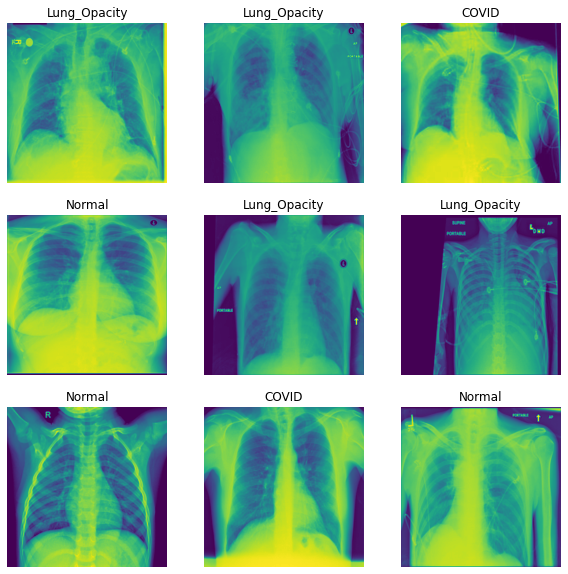

In [16]:
plt.figure(figsize=(10, 10))
for images, labels in train.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")



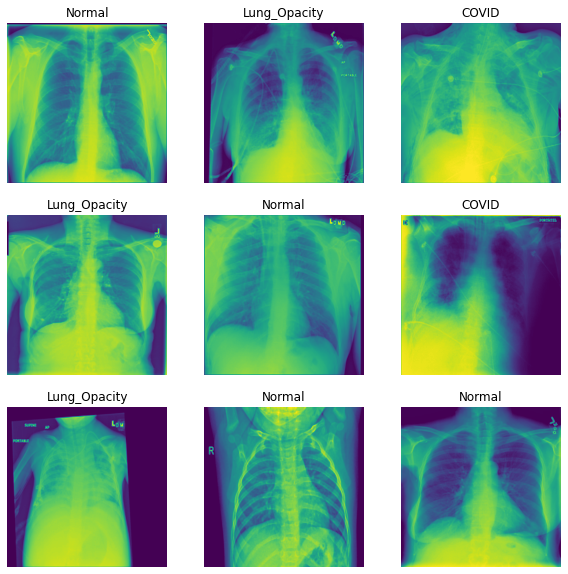

In [17]:
plt.figure(figsize=(10, 10))
for images, labels in val.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

Se realiza data-augmentation al dataset para obtener transformaciones aleatorias a las imagenes de forma realista, de tal forma que el modelo se entrene utilizando diferentes imagenes y como un intento de evitar sobreajuste

In [15]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
    ]
)

In [16]:
augmented_train = train.map(lambda x, y: (data_augmentation(x, training=True), y))


In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val = val.cache().prefetch(buffer_size=AUTOTUNE)


In [33]:
#Estimación de pesos de las clases en el dataset de entrenamiento
labels=np.concatenate([i for x, i in train], axis=0)

class_weights = class_weight.compute_class_weight(class_weight='balanced',classes=np.unique(labels),y=labels)

c_w={}
for i,j in zip(range(4),class_weights):
    c_w[i]=j
    
c_w

{0: 1.456140350877193,
 1: 0.8773056994818653,
 2: 0.5202162959321617,
 3: 3.982126058325494}

## Entrenamiento del modelo

#### Modelo base MLP

In [28]:
h_params={"n_layer1":300,"n_layer2":100,"n_layer3":10,"n_layer4":4,"dropout_1":0.2,"dropout_2":0.2,"dropout_3":0.2,
         "dropout_4":0.2}

model_mlp = keras.models.Sequential([
    #data_augmentation,
    keras.layers.Flatten(input_shape=[299, 299]),
    keras.layers.Dropout(h_params["dropout_1"], input_shape=(2,)),
    keras.layers.Dense(h_params["n_layer1"], activation="relu"),
    keras.layers.Dropout(h_params["dropout_2"], input_shape=(2,)),
    keras.layers.Dense(h_params["n_layer2"], activation="relu"),
    keras.layers.Dropout(h_params["dropout_3"], input_shape=(2,)),
    keras.layers.Dense(h_params["n_layer3"], activation="relu"),
    keras.layers.Dropout(h_params["dropout_4"], input_shape=(2,)),
    keras.layers.Dense(h_params["n_layer4"], activation="softmax")
])

model_mlp.compile(loss="sparse_categorical_crossentropy", # Tienen la justificacion para usarlo
              optimizer="adam",  # Tienen la justificacion para usarlo (funciona)
              metrics=["accuracy"]) 

In [ ]:
model_mlp.summary()

In [29]:
history_mlp = model_mlp.fit(train, epochs=10,validation_data=(val),class_weight=c_w)

Epoch 1/10
530/530 [==============================] - 94s 177ms/step - loss: 188.9363 - accuracy: 0.3964 - val_loss: 1.3819 - val_accuracy: 0.4855
Epoch 2/10
530/530 [==============================] - 88s 165ms/step - loss: 5.0236 - accuracy: 0.2970 - val_loss: 1.3837 - val_accuracy: 0.4855
Epoch 3/10
530/530 [==============================] - 87s 164ms/step - loss: 1.8074 - accuracy: 0.3299 - val_loss: 1.3859 - val_accuracy: 0.4855
Epoch 4/10
530/530 [==============================] - 97s 183ms/step - loss: 1.4838 - accuracy: 0.3423 - val_loss: 1.3876 - val_accuracy: 0.0666
Epoch 5/10
530/530 [==============================] - 96s 181ms/step - loss: 1.5814 - accuracy: 0.1328 - val_loss: 1.3835 - val_accuracy: 0.4855
Epoch 6/10
530/530 [==============================] - 97s 182ms/step - loss: 1.4575 - accuracy: 0.2838 - val_loss: 1.3863 - val_accuracy: 0.0666
Epoch 7/10
530/530 [==============================] - 92s 173ms/step - loss: 1.4848 - accuracy: 0.1754 - val_loss: 1.3863 - val_

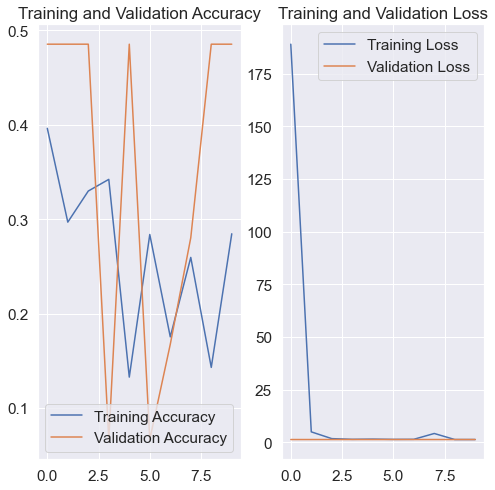

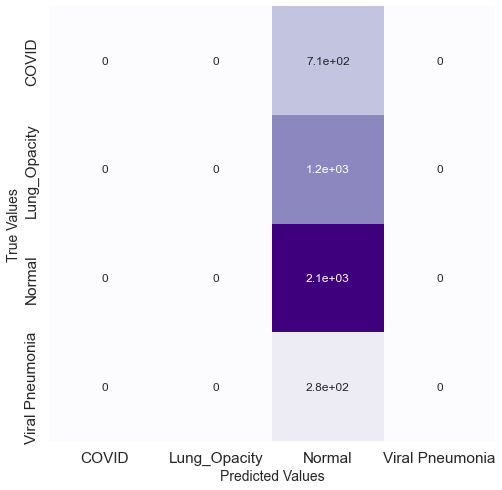


Normal
Viral Pneumonia-544.png
Normal
Viral Pneumonia-351.png
Normal
Viral Pneumonia-1333.png
Normal
Viral Pneumonia-557.png
Normal
Viral Pneumonia-333.png
Normal
Viral Pneumonia-577.png
Normal
Viral Pneumonia-1152.png
Normal
Viral Pneumonia-1193.png
Normal
Viral Pneumonia-653.png
Normal
Viral Pneumonia-262.png

Normal
Lung_Opacity-3328.png
Normal
Lung_Opacity-3043.png
Normal
Lung_Opacity-2250.png
Normal
Lung_Opacity-2540.png
Normal
Lung_Opacity-4354.png
Normal
Lung_Opacity-316.png
Normal
Lung_Opacity-5173.png
Normal
Lung_Opacity-3288.png
Normal
Lung_Opacity-2319.png
Normal
Lung_Opacity-3960.png

Normal
Normal-5797.png
Normal
Normal-9532.png
Normal
Normal-9046.png
Normal
Normal-2284.png
Normal
Normal-7873.png
Normal
Normal-6669.png
Normal
Normal-6530.png
Normal
Normal-3725.png
Normal
Normal-3496.png
Normal
Normal-5661.png

Normal
COVID-98.png
Normal
COVID-2592.png
Normal
COVID-1844.png
Normal
COVID-1895.png
Normal
COVID-1783.png
Normal
COVID-2654.png
Normal
COVID-1537.png
Normal
COVID

In [31]:
get_train_report(history_mlp,model_mlp,10)

In [21]:
def get_train_report(history,model,n_epochs):
    epochs = n_epochs
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()
    from sklearn.metrics import classification_report, confusion_matrix
    y_pred = model.predict(val)
    predicted_categories = tf.argmax(y_pred, axis=1)
    true_categories = tf.concat([y for x, y in val], axis=0)

    import seaborn as sns
    cm = confusion_matrix(true_categories, predicted_categories)
    fig = plt.figure(figsize = (8,8))
    ax1 = fig.add_subplot(1,1,1)
    sns.set(font_scale=1.4) #for label size
    sns.heatmap(cm, annot=True, annot_kws={"size": 12},
         cbar = False, cmap='Purples',xticklabels=val_class_names,yticklabels=val_class_names);
    ax1.set_ylabel('True Values',fontsize=14)
    ax1.set_xlabel('Predicted Values',fontsize=14)
    plt.show()
    import os 


    for folder in os.listdir("COVID-19_Radiography_Dataset"):
        print()
        for image in np.random.choice(os.listdir("COVID-19_Radiography_Dataset/"+folder),10):
            true_label=image.split('-')[0]

            img = tf.keras.utils.load_img(
        "COVID-19_Radiography_Dataset/{}/{}".format(folder,image), target_size=(img_height, img_width), color_mode="grayscale",
    )
            img_array = tf.keras.utils.img_to_array(img)
            img_array = tf.expand_dims(img_array, 0) # Create a batch


            predictions = model_mlp.predict(img_array)

            score = tf.nn.softmax(predictions[0])

            print(
                "{}"
                .format(class_names[np.argmax(score)])
            )
            print(image)


In [ ]:
model_cnn = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 1)),
  layers.Conv2D(16, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 1, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(4)
])

model_cnn.compile(loss="sparse_categorical_crossentropy", # Tienen la justificacion para usarlo
              optimizer="adam",  # Tienen la justificacion para usarlo (funciona)
              metrics=["accuracy"]) 

In [198]:
history_cnn = model_cnn.fit(train, epochs=5,validation_data=(val),class_weight=c_w)

Epoch 1/5
530/530 [==============================] - 9s 16ms/step - loss: 1.3863 - accuracy: 0.1718 - val_loss: 1.3863 - val_accuracy: 0.1682
Epoch 2/5
530/530 [==============================] - 8s 16ms/step - loss: 1.3863 - accuracy: 0.1718 - val_loss: 1.3863 - val_accuracy: 0.1682
Epoch 3/5
530/530 [==============================] - 8s 16ms/step - loss: 1.3863 - accuracy: 0.1718 - val_loss: 1.3863 - val_accuracy: 0.1682
Epoch 4/5
530/530 [==============================] - 8s 16ms/step - loss: 1.3863 - accuracy: 0.1718 - val_loss: 1.3863 - val_accuracy: 0.1682
Epoch 5/5
530/530 [==============================] - 8s 16ms/step - loss: 1.3863 - accuracy: 0.1718 - val_loss: 1.3863 - val_accuracy: 0.1682


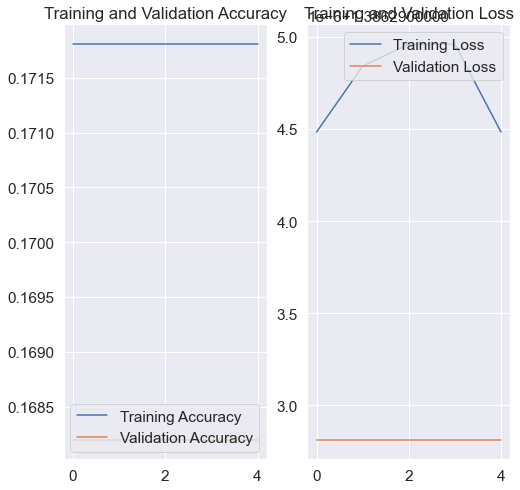

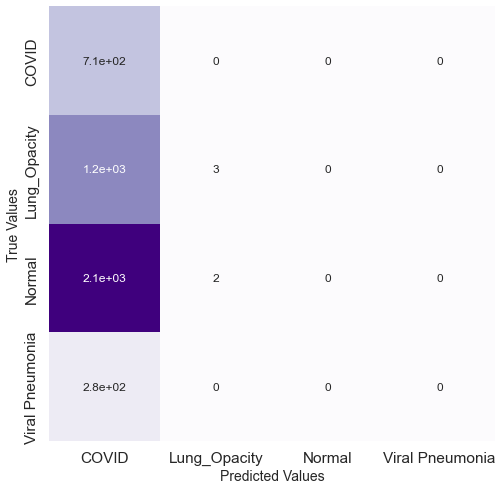


Lung_Opacity
COVID-1727.png
Lung_Opacity
COVID-1084.png
Lung_Opacity
COVID-2679.png
Lung_Opacity
COVID-2555.png
Lung_Opacity
COVID-1795.png
Lung_Opacity
COVID-1677.png
Lung_Opacity
COVID-2376.png
Lung_Opacity
COVID-294.png
Lung_Opacity
COVID-987.png
Lung_Opacity
COVID-2904.png

Lung_Opacity
Lung_Opacity-718.png
Lung_Opacity
Lung_Opacity-5165.png
Lung_Opacity
Lung_Opacity-1440.png
Lung_Opacity
Lung_Opacity-3987.png
Lung_Opacity
Lung_Opacity-2460.png
Lung_Opacity
Lung_Opacity-559.png
Lung_Opacity
Lung_Opacity-1107.png
Lung_Opacity
Lung_Opacity-4828.png
Lung_Opacity
Lung_Opacity-3319.png
Lung_Opacity
Lung_Opacity-3471.png

Lung_Opacity
Normal-9549.png
Lung_Opacity
Normal-8704.png
Lung_Opacity
Normal-2026.png
Lung_Opacity
Normal-1946.png
Lung_Opacity
Normal-4469.png
Lung_Opacity
Normal-3339.png
Lung_Opacity
Normal-9766.png
Lung_Opacity
Normal-1856.png
Lung_Opacity
Normal-12.png
Lung_Opacity
Normal-2881.png

Lung_Opacity
Viral Pneumonia-428.png
Lung_Opacity
Viral Pneumonia-902.png
Lung_Opa

In [211]:
get_train_report(history_cnn,model_cnn,5)

# Redes convolucionales (todavia no es seguro si va)

In [ ]:


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

In [46]:
model = keras.Sequential(
    [
        keras.Input(shape=image_size+(3,)),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(4, activation="softmax"),
    ]
)

In [50]:
batch_size = 128
epochs = 15

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/15


ValueError: in user code:

    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\losses.py:1665 categorical_crossentropy
        return backend.categorical_crossentropy(
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\backend.py:4839 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1161 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 4) are incompatible


In [47]:
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9849932462477848305
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22727688192
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16561403990029547815
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:09:00.0, compute capability: 8.6"
]


In [48]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)

Epoch 1/50


ValueError: in user code:

    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:853 train_function  *
        return step_function(self, iterator)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:842 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1286 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2849 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:3632 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:835 run_step  **
        outputs = model.train_step(data)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\training.py:788 train_step
        loss = self.compiled_loss(
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\engine\compile_utils.py:201 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\losses.py:141 __call__
        losses = call_fn(y_true, y_pred)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\losses.py:245 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\losses.py:1809 binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\keras\backend.py:5000 binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(labels=target, logits=output)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:245 sigmoid_cross_entropy_with_logits_v2
        return sigmoid_cross_entropy_with_logits(
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\util\dispatch.py:206 wrapper
        return target(*args, **kwargs)
    C:\Users\david\.conda\envs\tf_gpu\lib\site-packages\tensorflow\python\ops\nn_impl.py:132 sigmoid_cross_entropy_with_logits
        raise ValueError("logits and labels must have the same shape (%s vs %s)" %

    ValueError: logits and labels must have the same shape ((None, 4) vs (None, 1))
